In [1]:
import torch

In [2]:
# Read data
data_path = '/home/angelika/pixelsplat_fisheye/datasets/acid/train/000000.torch'
data = torch.load(data_path)

# The data is stored in a list of one element, which is a dictionary
data[0].keys()

dict_keys(['url', 'timestamps', 'cameras', 'images', 'key'])

In [3]:
print('Url')
print(data[0]['url'])

print('Timestamps')
print(data[0]['timestamps'].shape)
print(data[0]['timestamps'][0])

print('Cameras')
print(data[0]['cameras'].shape)  # 18 camera parameters for each of the images
print(data[0]['cameras'][0])

print('Images')
print(len(data[0]['images']))  # There are 256 images
print(data[0]['images'][0])   # Image 0
print(data[0]['images'][0].shape)

print('Key')
print(data[0]['key'])  # scene name

Url
https://www.youtube.com/watch?v=-E1q-K738Hk
Timestamps
torch.Size([256])
tensor(16080000)
Cameras
torch.Size([256, 18])
tensor([ 7.5774e-01,  1.3471e+00,  5.0000e-01,  5.0000e-01,  0.0000e+00,
         0.0000e+00,  9.9997e-01,  9.5093e-04, -7.1430e-03, -1.9739e-02,
        -1.0768e-03,  9.9984e-01, -1.7642e-02, -2.5716e-01,  7.1251e-03,
         1.7650e-02,  9.9982e-01,  8.0739e-01])
Images
256
tensor([255, 216, 255,  ...,  15, 255, 217], dtype=torch.uint8)
torch.Size([73335])
Key
a459940b42a66c49


In [4]:
data[0]['images'][0].numpy().tobytes()

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01h\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98

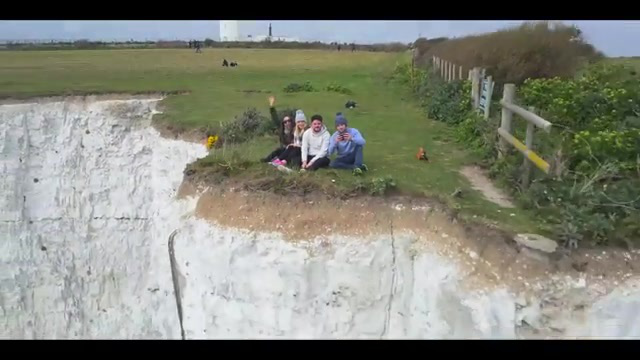

In [5]:
# PixelSplat Dataloader
# /home/angelika/pixelsplat_fisheye/src/dataset/dataset_re10k.py

from PIL import Image
from io import BytesIO

image_id = 0

# Load an image as in the PixelSplat dataloader
image = Image.open(BytesIO(data[0]['images'][image_id].numpy().tobytes()))
image

In [6]:
image.size

(640, 360)

In [10]:
import torchvision.transforms as tf

# Convert the image to a tensor
to_tensor = tf.ToTensor()
im = to_tensor(image)
im.shape

torch.Size([3, 360, 640])

In [20]:
from einops import rearrange, repeat

# Poses
print("Camera parameters shape: ", data[0]['cameras'].shape)
print("Camera parameters: ", data[0]['cameras'][0])

poses = data[0]['cameras']       # shape: (256, 18)
b = poses.shape[0]  # 256


# Copied from pixelsplat_fisheye/src/dataset/dataset_re10k.py

# Convert the intrinsics to a 3x3 normalized K matrix.
intrinsics = torch.eye(3, dtype=torch.float32)
intrinsics = repeat(intrinsics, "h w -> b h w", b=b).clone()
print("Intrinsics parameters shape: ", intrinsics.shape)          # shape: (256, 3, 3)

fx, fy, cx, cy = poses[:, :4].T  # shape: (4, 256)
intrinsics[:, 0, 0] = fx         # shape: (256)
intrinsics[:, 1, 1] = fy
intrinsics[:, 0, 2] = cx
intrinsics[:, 1, 2] = cy

# Convert the extrinsics to a 4x4 OpenCV-style W2C matrix.
w2c = repeat(torch.eye(4, dtype=torch.float32), "h w -> b h w", b=b).clone()   # shape: (256, 4, 4)
w2c[:, :3] = rearrange(poses[:, 6:], "b (h w) -> b h w", h=3, w=4)  # shape: (256, 3, 4)
extrinsics =  w2c.inverse()
print("Extrinsics parameters shape: ", extrinsics.shape)   # shape: (256, 4, 4)


Camera parameters shape:  torch.Size([256, 18])
Camera parameters:  tensor([ 7.5774e-01,  1.3471e+00,  5.0000e-01,  5.0000e-01,  0.0000e+00,
         0.0000e+00,  9.9997e-01,  9.5093e-04, -7.1430e-03, -1.9739e-02,
        -1.0768e-03,  9.9984e-01, -1.7642e-02, -2.5716e-01,  7.1251e-03,
         1.7650e-02,  9.9982e-01,  8.0739e-01])
Intrinsics parameters shape:  torch.Size([256, 3, 3])
Extrinsics parameters shape:  torch.Size([256, 4, 4])


In [24]:
repeat(torch.eye(4, dtype=torch.float32), "h w -> b h w", b=b)

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        ...,

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])

In [16]:
extrinsics[0]

tensor([[ 9.9997e-01, -1.0768e-03,  7.1251e-03,  1.3709e-02],
        [ 9.5093e-04,  9.9984e-01,  1.7650e-02,  2.4289e-01],
        [-7.1430e-03, -1.7642e-02,  9.9982e-01, -8.1192e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [22]:
poses[0]

tensor([ 7.5774e-01,  1.3471e+00,  5.0000e-01,  5.0000e-01,  0.0000e+00,
         0.0000e+00,  9.9997e-01,  9.5093e-04, -7.1430e-03, -1.9739e-02,
        -1.0768e-03,  9.9984e-01, -1.7642e-02, -2.5716e-01,  7.1251e-03,
         1.7650e-02,  9.9982e-01,  8.0739e-01])

In [13]:
intrinsics[0]

tensor([[0.7577, 0.0000, 0.5000],
        [0.0000, 1.3471, 0.5000],
        [0.0000, 0.0000, 1.0000]])

In [14]:
gamma1: 1.3363220825849971e+03
gamma2: 1.3357883350012958e+03
u0: 7.1694323510126321e+02
v0: 7.0576498308221585e+02